In [1]:
### UTILITIES
from keras.utils import to_categorical
import pickle
import sys
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

def load_images_from_folder(folder_path, image_size):
    images = []
    labels = []

    for label, class_folder in enumerate(sorted(os.listdir(folder_path))):
        class_path = os.path.join(folder_path, class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

def load_dataset(batch_size, num_classes, epochs, image_size, data_dir):
    x_train, y_train = load_images_from_folder(data_dir, image_size)

    # Splitting the data into training and testing sets
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Convert labels to one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # Randomly select 500 images for validation
    random_indices = np.random.choice(len(x_test), size=2000, replace=False)
    x_val = x_test[random_indices]
    y_val = y_test[random_indices]

    dataset = {
        'batch_size': batch_size,
        'num_classes': num_classes,
        'epochs': epochs,
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val,
        'x_test': x_test,  
        'y_test': y_test
    }

    return dataset


def save_network(network):
    #object_file = open(network.name + '.obj', 'wb')
    #pickle.dump(network, object_file)
    #tf.keras.models.save_model(network, network.name)

    model_path = network.name + '_model.h5'
    tf.keras.models.save_model(network.model, model_path)

    # Save the rest of the network information
    network_info = {
        'name': network.name,
        'block_list': network.block_list,
        'fitness': network.fitness
    }
    network_info_path = network.name + '_info.pkl'
    with open(network_info_path, 'wb') as info_file:
        pickle.dump(network_info, info_file)


def load_network(name):
    model_path = name + '_model.h5'
    loaded_model = tf.keras.models.load_model(model_path)

    # Load the network information
    info_path = name + '_info.pkl'
    with open(info_path, 'rb') as info_file:
        network_info = pickle.load(info_file)

    # Create a new Network instance
    loaded_network = Network(0)  # Update with appropriate 'it' value

    # Set the attributes of the loaded network
    loaded_network.name = network_info['name']
    loaded_network.block_list = network_info['block_list']
    loaded_network.fitness = network_info['fitness']
    loaded_network.model = loaded_model

    return loaded_network



def order_indexes(self):
    i = 0
    for block in self.block_list:
        block.index = i
        i += 1


def plot_training(history):                                           # plot diagnostic learning curves
    plt.figure(figsize=[8, 6])  # accuracy curves
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)  # <-- Change 'val_acc' to 'val_accuracy'
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_acc_plot.png')
    plt.close()



def plot_statistics(stats):
    plt.figure(figsize=[8, 6])											# fitness curves
    plt.plot([s[0] for s in stats], 'r', linewidth=3.0)
    plt.plot([stats[0][0]] * len(stats), 'b', linewidth=3.0)
    plt.legend(['BestFitness', 'InitialFitness'], fontsize=18)
    plt.xlabel('Generations', fontsize=16)
    plt.ylabel('FitnessValue', fontsize=16)
    plt.title('Fitness Curve', fontsize=16)
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_fitness_plot.png')

    plt.figure(figsize=[8, 6])											# parameters curves
    plt.plot([s[1] for s in stats], 'r', linewidth=3.0)
    plt.plot([stats[0][1]] * len(stats), 'b', linewidth=3.0)
    plt.legend(['BestParamsNum', 'InitialParamsNum'], fontsize=18)
    plt.xlabel('Generations', fontsize=16)
    plt.ylabel('ParamsNum', fontsize=16)
    plt.title('Parameters Curve', fontsize=16)
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_params_plot.png')
    plt.close()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# INOUT
import os
def compute_parent(dataset):
    if os.path.isfile('parent_0.h5'):
        daddy = load_network('parent_0')
        model = tf.keras.models.load_model('parent_0.h5')
        print("Loading parent_0")
        print("SUMMARY OF", daddy.name)
        print(model.summary())
        print("FITNESS:", daddy.fitness)
        return daddy

    daddy = Network(0)
    
    
    #INI BLOCK
    layerList1 = [
        Convolutional(filters=32, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(0, 0, layerList1, layerList2))
    
    #MIDDLE BLOCK 1
    layerList1 = [
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 1, layerList1, layerList2))

     #MIDDLE BLOCK 2
    layerList1 = [
        Convolutional(filters=128, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=128, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 2, layerList1, layerList2))

    
    #MIDDLE BLOCK 3
    layerList1 = [
        Convolutional(filters=256, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=256, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 3, layerList1, layerList2))
    
    
    
    #MIDDLE BLOCK 4
    layerList1 = [
        Convolutional(filters=512, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=512, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 4, layerList1, layerList2))
    
    
    
    #FULLY CONNECTED LAYER
    layerList1 = [
        FlattenLayer(),
        FullyConnected(units=128, num_classes=dataset['num_classes'])
    ]
    layerList2 = []
    daddy.block_list.append(Block(2, 5, layerList1, layerList2))
    
    

    model = daddy.build_model()
    print("Type of model_final:", type(model))
    daddy.train_and_evaluate(model, dataset)
    return daddy

In [3]:
# NETWORK
import tensorflow as tf
import os
import pickle
from keras.callbacks import Callback
from keras.models import Sequential
from random import randint, choice
from copy import deepcopy


class Network:
    __slots__ = ('name', 'block_list', 'fitness', 'model')

    def __init__(self, it):
        self.name = 'parent_' + str(it) if it == 0 else 'net_' + str(it)
        self.block_list = []
        self.fitness = None
        self.model = None

    """def build_model(self):
        model = Sequential()                                # create model
        for block in self.block_list:
            for layer in block.get_layers():                # build model
                try:
                    layer.build_layer(model)
                except:
                    print("\nINDIVIDUAL ABORTED, CREATING A NEW ONE\n")
                    return -1
        return model"""
    def build_model(self):
        model = Sequential()              
        print("The block is:")
        print(self.block_list)                 # create model
        for block in self.block_list:
            #print("Building block type:", block.type)
            #print("TOTAL :::")
            #print(block.get_layer_name())
            for layer in block.get_layers():                # build model
                #print("Adding layer:", layer.name)
                try:
                    layer.build_layer(model)
                    print("Layer added successfully.")
                except Exception as e:
                    print("Error occurred while adding layer:", e)
                    print("Returning None.")
                    return -1
        print("Model successfully built.")
        return model

    def train_and_evaluate(self, model, dataset):
        print("Training", self.name)
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        try:
            history = model.fit(dataset['x_train'],
                                dataset['y_train'],
                                batch_size=dataset['batch_size'],
                                epochs=dataset['epochs'],
                                validation_data=(dataset['x_val'], dataset['y_val']),
                                shuffle=True)
        except Exception as e:
            print("An error occurred during model training:", e)
            return -1
            # You can choose to handle the error in a specific way here, like logging it or taking corrective actions.


        # Extract metrics from the training history
        training_loss = history.history['loss'][-1]
        training_accuracy = history.history['accuracy'][-1]
        validation_loss = history.history['val_loss'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]

        # Additional metrics (you can customize this based on your needs)
        classification_error_rate = 1.0 - validation_accuracy

        self.model = model  # Save the model
        self.fitness = validation_loss  # Use validation loss as fitness

        # Print metrics
        print("SUMMARY OF", self.name)
        print("Training Loss:", training_loss)
        print("Training Accuracy:", training_accuracy)
        print("Validation Loss:", validation_loss)
        print("Validation Accuracy:", validation_accuracy)
        print("Classification Error Rate:", classification_error_rate)

        tf.keras.models.save_model(model, self.name + '.h5')         # save model
        #model.save(self.name + '.h5')                       # save model
        save_network(self)                                  # save topology, model and fitness

    def asexual_reproduction(self, it, dataset):

        # if the individual already exists, just load it
        if os.path.isfile('net_' + str(it) + '.h5'):
            print("\n-------------------------------------")
            print("Loading individual net_" + str(it))
            print("--------------------------------------\n")
            individual = load_network('net_' + str(it))
            model = tf.keras.models.load_model(individual.name + '.h5')
            print("SUMMARY OF", individual.name)
            print(model.summary())
            print("FITNESS: ", individual.fitness)
            return individual

        # otherwise, create the individual by mutating the parent
        individual = Network(it)

        print("\n-------------------------------------")
        print("\nCreating individual", individual.name)
        print("--------------------------------------\n")

        individual.block_list = deepcopy(self.block_list)           # copy the layer list from parent

        print("----->Strong Mutation")
        individual.block_mutation(dataset)                          # mutate a block
        individual.layer_mutation(dataset)                          # mutate a layer
        individual.parameters_mutation()                            # mutate some parameters

        model = individual.build_model()
        
        if model == -1:
            return self.asexual_reproduction(it, dataset)
        
        if(individual.train_and_evaluate(model, dataset)==-1):
            return self.asexual_reproduction(it, dataset)
        else:
            return individual
            

    def block_mutation(self, dataset):
        try:
            print("Block Mutation")

            print([(block.index, block.type) for block in self.block_list])

            # block list containing all the blocks with type = 1
            bl = [block.index for block in self.block_list if block.type == 1]

            if len(bl) == 0:
                print("Creating a new block with two Convolutional layers and a Pooling layer")
                self.block_list[1].index = 2
                layerList1 = [
                    Convolutional(filters=pow(2, randint(5, 8)),
                                  filter_size=(3, 3),
                                  stride_size=(1, 1),
                                  padding='same',
                                  input_shape=dataset['x_train'].shape[1:]),
                    Convolutional(filters=pow(2, randint(5, 8)),
                                  filter_size=(3, 3),
                                  stride_size=(1, 1),
                                  padding='same',
                                  input_shape=dataset['x_train'].shape[1:])
                ]
                layerList2 = [
                    Pooling(pool_size=(2, 2),
                            stride_size=(2, 2),
                            padding='same')
                ]
                b = Block(1, 1, layerList1, layerList2)
                self.block_list.insert(1, b)
                return

            block_idx = randint(1, max(bl))         # pick a random block among all the blocks with type = 1
            block_type_idx = randint(0, 1)          # 1 -> Conv2D; 0 -> Pooling or Dropout
            mutation_type = randint(0, 1)           # 1 -> remove; 0 -> add

            # list of layers of the selected block
            layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2
            length = len(layerList)

            if mutation_type:                                       # remove
                if length == 1:
                    del self.block_list[block_idx]
                elif block_type_idx:
                    pos = randint(0, length - 1)
                    print("Removing a Conv2D layer at", pos)
                    del layerList[pos]
                else:
                    pos = randint(0, length - 1)
                    print("Removing a Pooling/Dropout layer at", pos)
                    del layerList[pos]
            else:                                                   # add
                if block_type_idx:
                    print("Inserting a Convolutional layer")
                    layer = Convolutional(filters=pow(2, randint(5, 8)),
                                          filter_size=(3, 3),
                                          stride_size=(1, 1),
                                          padding='same',
                                          input_shape=dataset['x_train'].shape[1:])
                    layerList.insert(randint(0, length - 1), layer)
                else:
                    if randint(0, 1):                               # 1 -> Pooling; 0 -> Dropout
                        print("Inserting a Pooling layer")
                        layer = Pooling(pool_size=(2, 2),
                                        stride_size=(2, 2),
                                        padding='same')
                        layerList.insert(randint(0, length - 1), layer)
                    else:
                        print("Inserting a Dropout layer")
                        rate = choice([0.15, 0.25, 0.35, 0.50])
                        layer = Dropout(rate=rate)
                        layerList.insert(randint(0, length - 1), layer)
        except Exception as e:
            print(f"An error occurred during block mutation: {e}")
            return None

                    
                    
                    
                    
                    

    """def layer_mutation(self, dataset):
        print("Layer Mutation")

        # pick a random block among all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            return

        block_idx = randint(1, max(bl))
        block_type_idx = randint(0, 1)      # 1 -> Conv2D; 0 -> Pooling or Dropout

        # list of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2

        if len(layerList) == 0:
            if block_type_idx:
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                self.block_list[block_idx].layerList1.append(layer)
                return
            else:
                layer = Pooling(pool_size=(2, 2),
                                stride_size=(2, 2),
                                padding='same')
                self.block_list[block_idx].layerList2.append(layer)

        idx = randint(0, len(layerList) - 1)
        layer = layerList[idx]

        if layer.name == 'Conv2D':
            print("Splitting Conv2D layer at index", idx)
            layer.filters = int(layer.filters * 0.5)
            layerList.insert(idx, deepcopy(layer))
        elif layer.name == 'MaxPooling2D' or layer.name == 'AveragePooling2D':
            print("Changing Pooling layer at index", idx, "with Conv2D layer")
            del layerList[idx]
            conv_layer = Convolutional(filters=pow(2, randint(5, 8)),
                                       filter_size=(3, 3),
                                       stride_size=(2, 2),
                                       padding=layer.padding,
                                       input_shape=dataset['x_train'].shape[1:])
            layerList.insert(idx, conv_layer)"""
    
    def layer_mutation(self, dataset):
        print("Layer Mutation")

        # Determine the maximum number of layers that can be added or removed
        max_layers_to_add = 16 - sum(len(block.layerList1) + len(block.layerList2) for block in self.block_list)
        max_layers_to_remove = sum(len(block.layerList1) + len(block.layerList2) - 1 for block in self.block_list)

        if max_layers_to_add == 0 and max_layers_to_remove == 0:
            return

        # Pick a random block among all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            return

        block_idx = randint(1, max(bl))
        block_type_idx = randint(0, 1)      # 1 -> Conv2D; 0 -> Pooling or Dropout

        # List of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2

        if len(layerList) == 0:
            if block_type_idx:
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                self.block_list[block_idx].layerList1.append(layer)
            else:
                layer = Pooling(pool_size=(2, 2),
                                stride_size=(2, 2),
                                padding='same')
                self.block_list[block_idx].layerList2.append(layer)
        else:
            # Randomly choose whether to add or remove a layer
            add_layer = bool(randint(0, 1))

            if add_layer and max_layers_to_add > 0:
                # Add a layer
                layer = self.create_random_layer(dataset)
                layerList.insert(randint(0, len(layerList)), layer)
            elif not add_layer and max_layers_to_remove > 0:
                # Remove a layer
                idx = randint(0, len(layerList) - 1)
                del layerList[idx]

        # Ensure the total number of layers in the block doesn't exceed 16
        if len(self.block_list[block_idx].layerList1) + len(self.block_list[block_idx].layerList2) > 16:
            # Remove a random layer to maintain the total count of 16 layers
            block_layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2
            del block_layerList[randint(0, len(block_layerList) - 1)]

    def create_random_layer(self, dataset):
        # Create a random layer (Conv2D or Pooling)
        if randint(0, 1):
            # Conv2D layer
            return Convolutional(filters=pow(2, randint(5, 8)),
                                 filter_size=(3, 3),
                                 stride_size=(1, 1),
                                 padding='same',
                                 input_shape=dataset['x_train'].shape[1:])
        else:
            # Pooling layer
            return Pooling(pool_size=(2, 2),
                           stride_size=(2, 2),
                           padding='same')

            
            
            
            
            
            
            
            

    def parameters_mutation(self):
        print("Parameters Mutation")
        for block in self.block_list:
            for layer in block.get_layers():
                if randint(0, 1):
                    layer.mutate_parameters()

    def save_network_info(self, info_filename):
        network_info = {
            'name': self.name,
            'block_list': self.block_list,
            'fitness': self.fitness
        }

        with open(info_filename, 'wb') as info_file:
            pickle.dump(network_info, info_file)

    def load_network_info(self, info_filename):
        with open(info_filename, 'rb') as info_file:
            network_info = pickle.load(info_file)

        self.name = network_info['name']
        self.block_list = network_info['block_list']
        self.fitness = network_info['fitness']

    def save_model(self, model_filename):
        self.model.save(model_filename)

    def load_model(self, model_filename):
        self.model = tf.keras.models.load_model(model_filename)

    def save_network(self, network_info_filename, model_filename):
        # Save non-model attributes
        self.save_network_info(network_info_filename)

        # Save the model separately
        self.save_model(model_filename)

    def load_network(self, network_info_filename, model_filename):
        # Load non-model attributes
        self.load_network_info(network_info_filename)

        # Load the model separately
        self.load_model(model_filename)


In [4]:
# TOPOLOGY

import keras.layers
from random import randint


class Block:
	__slots__ = ('type', 'index', 'layerList1', 'layerList2')

	def __init__(self, type, index, layerList1, layerList2):
		self.type = type										# 0 -> initial layer; 1 -> mid layers; 2 -> final layer
		self.index = index										# block index among all the blocks
		self.layerList1 = layerList1							# Convolutional layers
		self.layerList2 = layerList2							# Pooling and Dropout layers

	def get_layers(self):
		return self.layerList1 + self.layerList2

	def get_size(self):
		return len(self.get_layers())


class Convolutional:
	# __slots__ = ('name', 'filters', 'padding', 'filter_size', 'stride_size', 'input_shape')

	def __init__(self, filters, padding, filter_size, stride_size, input_shape):
		self.name = 'Conv2D'
		self.filters = filters
		self.padding = padding
		self.filter_size = filter_size
		self.stride_size = stride_size
		self.input_shape = input_shape

	def build_layer(self, model):
		try:
			model.add(keras.layers.Conv2D(filters=self.filters,
											kernel_size=self.filter_size,
											strides=self.stride_size,
											padding=self.padding,
											activation='relu',
											kernel_initializer='he_uniform',
											input_shape=self.input_shape))
		except ValueError as e:
			print("Error occurred while adding layer:", e)
			print("Skipping current architecture.")
			return  # Skip adding this layer
	def mutate_parameters(self):
		mutation = randint(0, 2)  # Adjusted the number of mutations
		print("Mutating", self.name, "layer:")
		if mutation == 0 and self.filters >= 64:  # Adjusted the filter reduction threshold
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 1 and self.filters <= 256:  # Adjusted the filter increase threshold
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 2:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)

        

        


	"""def mutate_parameters(self):
		mutation = randint(0, 4)
		print("Mutating", self.name, "layer:")
		if mutation == 0 and self.filters >= 32:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 1 and self.filters >= 32:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 2 and self.filters <= 512:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 3 and self.filters <= 512:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 4:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)
"""
    

'''
elif mutation is 4:
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size, " and ", end="")
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size)
'''


class Pooling:
	__slots__ = ('name', 'pool_size', 'stride_size', 'padding')

	def __init__(self, pool_size, stride_size, padding):
		self.name = 'MaxPooling2D'
		self.pool_size = pool_size
		self.stride_size = stride_size
		self.padding = padding

	def build_layer(self, model):
		if self.name == 'MaxPooling2D':
			model.add(keras.layers.MaxPooling2D(self.pool_size, self.stride_size, self.padding))
		elif self.name == 'AveragePooling2D':
			model.add(keras.layers.AveragePooling2D(self.pool_size, self.stride_size, self.padding))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 1)
		if mutation == 0:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)
		elif mutation == 1:
			if self.name == 'MaxPooling2D':
				print("-->changed self.name from ", self.name, " ", end="")
				self.name = 'AveragePooling2D'
				print("to ", self.name)
			else:
				print("-->changed self.name from ", self.name, " ", end="")
				self.name = 'MaxPooling2D'
				print("to ", self.name)


'''
if mutation is 0:
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size)
'''


class FullyConnected:
	__slots__ = ('name', 'units', 'num_classes')

	def __init__(self, units, num_classes):
		self.name = "FullyConnected"
		self.units = units
		self.num_classes = num_classes

	def build_layer(self, model):
		model.add(keras.layers.Flatten())
		model.add(keras.layers.Dense(self.units, activation='relu', kernel_initializer='he_uniform'))
		model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 2)
		if mutation == 0:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units *= 2
			print("to ", self.units)
		elif mutation == 1:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units *= 2
			print("to ", self.units)
		elif mutation == 2:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units /= 2
			print("to ", self.units)


'''
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(self.num_classes, activation='softmax'))
'''


class Dropout:
	__slots__ = ('name', 'rate')

	def __init__(self, rate):
		self.name = "Dropout"
		self.rate = rate

	def build_layer(self, model):
		model.add(keras.layers.Dropout(self.rate))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 3)
		if mutation == 0 and self.rate <= 0.85:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate + 0.10
			print("to ", self.rate)
		elif mutation == 1 and self.rate <= 0.90:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate + 0.05
			print("to ", self.rate)
		elif mutation == 2 and self.rate >= 0.15:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate - 0.10
			print("to ", self.rate)
		elif mutation == 3 and self.rate >= 0.10:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate - 0.05
			print("to ", self.rate)

class FlattenLayer:
    def __init__(self):
        self.name = 'Flatten'

    def build_layer(self, model):
        model.add(keras.layers.Flatten())

    def mutate_parameters(self):
        # The Flatten layer does not have any parameters to mutate
        pass


Genetic Algorithm
----->Initializing Population
The block is:
[<__main__.Block object at 0x7d4cb9c5db40>, <__main__.Block object at 0x7d4cb9c71a00>, <__main__.Block object at 0x7d4cb98dd3c0>, <__main__.Block object at 0x7d4cb99423c0>, <__main__.Block object at 0x7d4cb99425c0>, <__main__.Block object at 0x7d4cb9942800>]
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Model successfully built.
Type of model_final: <class 'keras.src.engine.sequential.Sequential'>
Training parent_0
Epoch 1/30
300/300 [==============================] - 9s 12ms/step - loss: 2.9596 - accuracy: 0.1191 - val_loss: 2.6640 - val_accuracy: 0.1790
Epoch 

/tmp/ipykernel_26/67157677.py:86: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, self.name + '.h5')         # save model
/tmp/ipykernel_26/2505184454.py:68: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(network.model, model_path)


Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Model successfully built.
Training net_1
Epoch 1/30
300/300 [==============================] - 6s 9ms/step - loss: 3.0480 - accuracy: 0.0607 - val_loss: 2.8799 - val_accuracy: 0.0860
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.7153 - accuracy: 0.1736 - val_loss: 4.3095 - val_accuracy: 0.1025
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2768 - accuracy: 0.3291 - val_loss: 4.5161 - val_accuracy: 0.1055
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 1.9245 - accuracy: 0.4332 - val_loss: 2.176

2024-04-08 09:42:21.435708: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 13ms/step - loss: 3.1992 - accuracy: 0.0680 - val_loss: 2.9896 - val_accuracy: 0.0615
Epoch 2/30
300/300 [==============================] - 3s 10ms/step - loss: 3.1567 - accuracy: 0.2247 - val_loss: 2.6941 - val_accuracy: 0.2375
Epoch 3/30
300/300 [==============================] - 3s 10ms/step - loss: 2.1980 - accuracy: 0.3603 - val_loss: 2.0654 - val_accuracy: 0.3805
Epoch 4/30
300/300 [==============================] - 3s 10ms/step - loss: 1.9407 - accuracy: 0.4437 - val_loss: 2.2851 - val_accuracy: 0.4350
Epoch 5/30
300/300 [==============================] - 3s 10ms/step - loss: 2.0677 - accuracy: 0.5192 - val_loss: 1.8277 - val_accuracy: 0.4910
Epoch 6/30
300/300 [==============================] - 3s 10ms/step - loss: 2.2858 - accuracy: 0.5722 - val_loss: 2.3954 - val_accuracy: 0.4730
Epoch 7/30
300/300 [==============================] - 3s 10ms/step - loss: 2.9523 - accuracy: 0.6272 - val_loss: 2.6485 - val_accuracy: 0.4670
Epoch 8/30

2024-04-08 09:43:58.655592: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 3.0261 - accuracy: 0.0898 - val_loss: 2.9005 - val_accuracy: 0.1310
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4937 - accuracy: 0.2564 - val_loss: 2.9660 - val_accuracy: 0.2730
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.1407 - accuracy: 0.3554 - val_loss: 2.2730 - val_accuracy: 0.3390
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 1.9314 - accuracy: 0.4279 - val_loss: 1.9663 - val_accuracy: 0.4035
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.8174 - accuracy: 0.4767 - val_loss: 2.0665 - val_accuracy: 0.3960
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 1.7263 - accuracy: 0.5229 - val_loss: 2.0057 - val_accuracy: 0.4445
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.7503 - accuracy: 0.5578 - val_loss: 2.4383 - val_accuracy: 0.3845
Epoch 8/30
300/30

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Creating Child 1
----->Elitism selection
Selected net_4 and parent_0 for reproduction
----->Crossover
Child has been created
----->Soft Mutation
Layer Mutation
Parameters Mutation
Mutating Conv2D layer:
-->changed self.padding from  same  to  valid
Mutating MaxPooling2D layer:
-->changed self.padding from  same  to  valid
Mutating Conv2D layer:
-->changed self.padding from  same  to  valid
Child has been mutated
The block is:
[<__main__.Block object at 0x7d4bf90f2840>, <__main__.Block object at 0x7d4bf812ab80>, <__main__.Block object at 0x7d47dc247c40>, <__main__.Block object at 0x7d47dc214f40>]
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Model successfully built.
Training net_11
Epoch 1/30
300/300 [==============================] - 4s 6ms/step - loss: 2.4584 - accuracy: 0.2673 - val_loss: 3.5003 -

2024-04-08 09:54:49.381883: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.9513 - accuracy: 0.0959 - val_loss: 2.6957 - val_accuracy: 0.1510
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4446 - accuracy: 0.2531 - val_loss: 3.6478 - val_accuracy: 0.1865
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.1194 - accuracy: 0.3637 - val_loss: 3.1481 - val_accuracy: 0.2745
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.9260 - accuracy: 0.4295 - val_loss: 2.3162 - val_accuracy: 0.3475
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.7187 - accuracy: 0.4851 - val_loss: 3.4916 - val_accuracy: 0.3150
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.5890 - accuracy: 0.5228 - val_loss: 2.0682 - val_accuracy: 0.4200
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.4620 - accuracy: 0.5565 - val_loss: 1.5982 - val_accuracy: 0.5285
Epoch 8/30
300/30

2024-04-08 09:56:43.705528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 3s 5ms/step - loss: 2.2334 - accuracy: 0.3364 - val_loss: 3.3373 - val_accuracy: 0.2755
Epoch 2/30
300/300 [==============================] - 1s 4ms/step - loss: 1.6253 - accuracy: 0.5055 - val_loss: 4.2452 - val_accuracy: 0.2985
Epoch 3/30
300/300 [==============================] - 1s 4ms/step - loss: 1.3666 - accuracy: 0.5845 - val_loss: 2.6748 - val_accuracy: 0.4535
Epoch 4/30
300/300 [==============================] - 1s 4ms/step - loss: 1.1577 - accuracy: 0.6428 - val_loss: 4.9698 - val_accuracy: 0.3480
Epoch 5/30
300/300 [==============================] - 1s 4ms/step - loss: 0.9891 - accuracy: 0.6944 - val_loss: 3.6221 - val_accuracy: 0.4340
Epoch 6/30
300/300 [==============================] - 1s 4ms/step - loss: 0.8181 - accuracy: 0.7426 - val_loss: 5.4677 - val_accuracy: 0.4010
Epoch 7/30
300/300 [==============================] - 1s 4ms/step - loss: 0.6823 - accuracy: 0.7866 - val_loss: 4.5500 - val_accuracy: 0.4500
Epoch 8/30
300/30

2024-04-08 09:59:04.897161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 9ms/step - loss: 3.6401 - accuracy: 0.0663 - val_loss: 3.0891 - val_accuracy: 0.0580
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 3.3128 - accuracy: 0.1599 - val_loss: 2.6356 - val_accuracy: 0.1985
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 4.4657 - accuracy: 0.2661 - val_loss: 2.4729 - val_accuracy: 0.2595
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 5.5179 - accuracy: 0.3155 - val_loss: 2.4835 - val_accuracy: 0.2810
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 5.2175 - accuracy: 0.3382 - val_loss: 2.2265 - val_accuracy: 0.3440
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 6.3300 - accuracy: 0.3621 - val_loss: 3.2637 - val_accuracy: 0.1095
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 13.4706 - accuracy: 0.3555 - val_loss: 4.6627 - val_accuracy: 0.1010
Epoch 8/30
300/3

2024-04-08 10:00:14.937094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 10ms/step - loss: 3.0822 - accuracy: 0.0731 - val_loss: 3.5048 - val_accuracy: 0.0605
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.8099 - accuracy: 0.1909 - val_loss: 2.4362 - val_accuracy: 0.2375
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 4.8389 - accuracy: 0.2920 - val_loss: 2.4832 - val_accuracy: 0.2780
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 3.3097 - accuracy: 0.3449 - val_loss: 2.4557 - val_accuracy: 0.2530
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 4.5095 - accuracy: 0.3885 - val_loss: 3.6955 - val_accuracy: 0.2560
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 6.5818 - accuracy: 0.4086 - val_loss: 2.4852 - val_accuracy: 0.2770
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 5.9574 - accuracy: 0.4327 - val_loss: 2.3421 - val_accuracy: 0.3320
Epoch 8/30
300/3

2024-04-08 10:02:30.875844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 11s 23ms/step - loss: 3.3949 - accuracy: 0.0484 - val_loss: 2.9959 - val_accuracy: 0.0515
Epoch 2/30
300/300 [==============================] - 6s 20ms/step - loss: 3.0107 - accuracy: 0.0480 - val_loss: 2.9957 - val_accuracy: 0.0340
Epoch 3/30
300/300 [==============================] - 6s 19ms/step - loss: 3.0004 - accuracy: 0.0536 - val_loss: 2.9964 - val_accuracy: 0.0510
Epoch 4/30
300/300 [==============================] - 6s 19ms/step - loss: 3.0128 - accuracy: 0.0486 - val_loss: 2.9965 - val_accuracy: 0.0510
Epoch 5/30
300/300 [==============================] - 6s 19ms/step - loss: 2.9961 - accuracy: 0.0489 - val_loss: 2.9966 - val_accuracy: 0.0510
Epoch 6/30
300/300 [==============================] - 6s 20ms/step - loss: 3.0053 - accuracy: 0.0479 - val_loss: 2.9967 - val_accuracy: 0.0455
Epoch 7/30
300/300 [==============================] - 6s 20ms/step - loss: 2.9959 - accuracy: 0.0499 - val_loss: 2.9967 - val_accuracy: 0.0455
Epoch 8/3

2024-04-08 10:05:31.999517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 12ms/step - loss: 3.2171 - accuracy: 0.0537 - val_loss: 2.9960 - val_accuracy: 0.0510
Epoch 2/30
300/300 [==============================] - 3s 10ms/step - loss: 2.9267 - accuracy: 0.0968 - val_loss: 2.7385 - val_accuracy: 0.1535
Epoch 3/30
300/300 [==============================] - 3s 10ms/step - loss: 2.6087 - accuracy: 0.2145 - val_loss: 2.3847 - val_accuracy: 0.2810
Epoch 4/30
300/300 [==============================] - 3s 10ms/step - loss: 2.3639 - accuracy: 0.2849 - val_loss: 2.4845 - val_accuracy: 0.2710
Epoch 5/30
300/300 [==============================] - 3s 10ms/step - loss: 2.2176 - accuracy: 0.3262 - val_loss: 2.5037 - val_accuracy: 0.2695
Epoch 6/30
300/300 [==============================] - 3s 10ms/step - loss: 2.1174 - accuracy: 0.3563 - val_loss: 2.1571 - val_accuracy: 0.3390
Epoch 7/30
300/300 [==============================] - 3s 10ms/step - loss: 2.0366 - accuracy: 0.3895 - val_loss: 1.9518 - val_accuracy: 0.4375
Epoch 8/30

2024-04-08 10:07:03.775936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 8s 14ms/step - loss: 3.0223 - accuracy: 0.0534 - val_loss: 2.9794 - val_accuracy: 0.0665
Epoch 2/30
300/300 [==============================] - 4s 12ms/step - loss: 2.9269 - accuracy: 0.0953 - val_loss: 2.9216 - val_accuracy: 0.0835
Epoch 3/30
300/300 [==============================] - 4s 12ms/step - loss: 2.7297 - accuracy: 0.1389 - val_loss: 2.7384 - val_accuracy: 0.1480
Epoch 4/30
300/300 [==============================] - 3s 12ms/step - loss: 2.6265 - accuracy: 0.1859 - val_loss: 2.8906 - val_accuracy: 0.1515
Epoch 5/30
300/300 [==============================] - 4s 12ms/step - loss: 2.9397 - accuracy: 0.2193 - val_loss: 2.4843 - val_accuracy: 0.2385
Epoch 6/30
300/300 [==============================] - 3s 12ms/step - loss: 4.8831 - accuracy: 0.2713 - val_loss: 2.3890 - val_accuracy: 0.2725
Epoch 7/30
300/300 [==============================] - 4s 12ms/step - loss: 3.6288 - accuracy: 0.3165 - val_loss: 2.3246 - val_accuracy: 0.2975
Epoch 8/30

2024-04-08 10:11:34.347392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_30/dropout_17/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 2.6495 - accuracy: 0.2179 - val_loss: 2.4301 - val_accuracy: 0.2540
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.1863 - accuracy: 0.4050 - val_loss: 2.2223 - val_accuracy: 0.3220
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.8459 - accuracy: 0.4949 - val_loss: 1.9709 - val_accuracy: 0.4590
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 2.7246 - accuracy: 0.5621 - val_loss: 1.8620 - val_accuracy: 0.4590
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 3.0305 - accuracy: 0.6127 - val_loss: 2.1767 - val_accuracy: 0.3720
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 3.4851 - accuracy: 0.6642 - val_loss: 2.0364 - val_accuracy: 0.5030
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 3.1114 - accuracy: 0.7091 - val_loss: 1.6213 - val_accuracy: 0.5675
Epoch 8/30
300/30

2024-04-08 10:12:58.404058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_34/dropout_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 10ms/step - loss: 3.1197 - accuracy: 0.0762 - val_loss: 2.8857 - val_accuracy: 0.1250
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.8670 - accuracy: 0.1643 - val_loss: 3.4273 - val_accuracy: 0.1740
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.6942 - accuracy: 0.2649 - val_loss: 2.8887 - val_accuracy: 0.2130
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 3.0415 - accuracy: 0.3010 - val_loss: 2.8111 - val_accuracy: 0.2125
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 2.8951 - accuracy: 0.3265 - val_loss: 2.4762 - val_accuracy: 0.2765
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.7211 - accuracy: 0.3474 - val_loss: 3.1643 - val_accuracy: 0.2550
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5437 - accuracy: 0.3579 - val_loss: 4.0699 - val_accuracy: 0.1595
Epoch 8/30
300/3

2024-04-08 10:19:16.810530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_40/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.9391 - accuracy: 0.1127 - val_loss: 2.4830 - val_accuracy: 0.2605
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3621 - accuracy: 0.2801 - val_loss: 2.6273 - val_accuracy: 0.2250
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.0716 - accuracy: 0.3712 - val_loss: 2.0774 - val_accuracy: 0.3755
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.8973 - accuracy: 0.4344 - val_loss: 3.0762 - val_accuracy: 0.2700
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.7567 - accuracy: 0.4714 - val_loss: 1.9593 - val_accuracy: 0.4255
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.6270 - accuracy: 0.5157 - val_loss: 1.9726 - val_accuracy: 0.4195
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.5161 - accuracy: 0.5456 - val_loss: 2.7433 - val_accuracy: 0.3875
Epoch 8/30
300/30

2024-04-08 10:21:24.577435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_42/dropout_23/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.7918 - accuracy: 0.1622 - val_loss: 5.0951 - val_accuracy: 0.1410
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2645 - accuracy: 0.3298 - val_loss: 2.3556 - val_accuracy: 0.3060
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 1.9181 - accuracy: 0.4344 - val_loss: 2.3788 - val_accuracy: 0.3865
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 1.6799 - accuracy: 0.5079 - val_loss: 1.9503 - val_accuracy: 0.4690
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 1.5146 - accuracy: 0.5833 - val_loss: 2.4201 - val_accuracy: 0.4450
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 1.2459 - accuracy: 0.6408 - val_loss: 2.2188 - val_accuracy: 0.4880
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.0659 - accuracy: 0.6912 - val_loss: 1.9628 - val_accuracy: 0.4985
Epoch 8/30
300/30

2024-04-08 10:22:49.009282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_43/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 8s 12ms/step - loss: 2.8810 - accuracy: 0.1224 - val_loss: 2.7508 - val_accuracy: 0.1245
Epoch 2/30
300/300 [==============================] - 3s 11ms/step - loss: 2.4806 - accuracy: 0.2507 - val_loss: 3.8624 - val_accuracy: 0.2140
Epoch 3/30
300/300 [==============================] - 3s 11ms/step - loss: 2.3572 - accuracy: 0.3430 - val_loss: 2.3150 - val_accuracy: 0.3735
Epoch 4/30
300/300 [==============================] - 3s 11ms/step - loss: 2.6124 - accuracy: 0.3953 - val_loss: 2.1887 - val_accuracy: 0.3635
Epoch 5/30
300/300 [==============================] - 3s 11ms/step - loss: 1.9703 - accuracy: 0.4288 - val_loss: 2.6030 - val_accuracy: 0.4355
Epoch 6/30
300/300 [==============================] - 3s 10ms/step - loss: 2.5218 - accuracy: 0.4656 - val_loss: 2.1685 - val_accuracy: 0.4150
Epoch 7/30
300/300 [==============================] - 3s 10ms/step - loss: 2.5038 - accuracy: 0.4971 - val_loss: 2.4345 - val_accuracy: 0.3950
Epoch 8/30

2024-04-08 10:24:29.083263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_45/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 11ms/step - loss: 3.0164 - accuracy: 0.0520 - val_loss: 2.9900 - val_accuracy: 0.0485
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.9655 - accuracy: 0.0813 - val_loss: 2.7280 - val_accuracy: 0.1195
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.6563 - accuracy: 0.1565 - val_loss: 2.5855 - val_accuracy: 0.1890
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.4516 - accuracy: 0.2299 - val_loss: 2.5501 - val_accuracy: 0.2140
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 2.2553 - accuracy: 0.3002 - val_loss: 2.2104 - val_accuracy: 0.3070
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.0708 - accuracy: 0.3673 - val_loss: 2.1076 - val_accuracy: 0.3660
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 1.9513 - accuracy: 0.4046 - val_loss: 1.8357 - val_accuracy: 0.4400
Epoch 8/30
300/3

2024-04-08 10:25:54.979538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_46/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 9ms/step - loss: 3.0379 - accuracy: 0.0806 - val_loss: 2.8158 - val_accuracy: 0.1020
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.7456 - accuracy: 0.1893 - val_loss: 2.7686 - val_accuracy: 0.1480
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 3.0275 - accuracy: 0.3106 - val_loss: 3.3340 - val_accuracy: 0.1815
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 5.7882 - accuracy: 0.3936 - val_loss: 2.1955 - val_accuracy: 0.3470
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 5.0286 - accuracy: 0.4482 - val_loss: 2.3342 - val_accuracy: 0.3120
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 5.0800 - accuracy: 0.5006 - val_loss: 1.7953 - val_accuracy: 0.4665
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 5.1711 - accuracy: 0.5398 - val_loss: 2.4030 - val_accuracy: 0.3170
Epoch 8/30
300/30

2024-04-08 10:27:09.268436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_54/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 9ms/step - loss: 2.9583 - accuracy: 0.0745 - val_loss: 2.9524 - val_accuracy: 0.0655
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.6745 - accuracy: 0.1760 - val_loss: 2.4880 - val_accuracy: 0.2110
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.4622 - accuracy: 0.2652 - val_loss: 2.7108 - val_accuracy: 0.2160
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2842 - accuracy: 0.3302 - val_loss: 2.5993 - val_accuracy: 0.2080
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3040 - accuracy: 0.3807 - val_loss: 2.1498 - val_accuracy: 0.3410
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.1570 - accuracy: 0.4214 - val_loss: 1.8966 - val_accuracy: 0.4245
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 2.0213 - accuracy: 0.4464 - val_loss: 2.3334 - val_accuracy: 0.3995
Epoch 8/30
300/30

2024-04-08 10:28:29.035521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_55/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 2.8067 - accuracy: 0.1304 - val_loss: 2.7452 - val_accuracy: 0.1690
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4703 - accuracy: 0.2780 - val_loss: 2.5792 - val_accuracy: 0.2505
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4372 - accuracy: 0.3606 - val_loss: 2.5846 - val_accuracy: 0.2250
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4346 - accuracy: 0.4120 - val_loss: 2.2474 - val_accuracy: 0.3670
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 2.6493 - accuracy: 0.4562 - val_loss: 2.0516 - val_accuracy: 0.4160
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 2.5834 - accuracy: 0.4863 - val_loss: 2.2392 - val_accuracy: 0.4145
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 2.2849 - accuracy: 0.5140 - val_loss: 2.0034 - val_accuracy: 0.4190
Epoch 8/30
300/30

2024-04-08 10:29:33.480043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_56/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 4s 7ms/step - loss: 2.9229 - accuracy: 0.1158 - val_loss: 2.5990 - val_accuracy: 0.2345
Epoch 2/30
300/300 [==============================] - 2s 6ms/step - loss: 2.4023 - accuracy: 0.2770 - val_loss: 2.1237 - val_accuracy: 0.3605
Epoch 3/30
300/300 [==============================] - 2s 6ms/step - loss: 2.1149 - accuracy: 0.3663 - val_loss: 2.1600 - val_accuracy: 0.3735
Epoch 4/30
300/300 [==============================] - 2s 6ms/step - loss: 1.9102 - accuracy: 0.4280 - val_loss: 1.8474 - val_accuracy: 0.4560
Epoch 5/30
300/300 [==============================] - 2s 6ms/step - loss: 1.7465 - accuracy: 0.4688 - val_loss: 1.6389 - val_accuracy: 0.5045
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.6010 - accuracy: 0.5115 - val_loss: 1.5027 - val_accuracy: 0.5540
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.4944 - accuracy: 0.5522 - val_loss: 1.6236 - val_accuracy: 0.5335
Epoch 8/30
300/30

2024-04-08 10:30:33.590748: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_57/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 4s 7ms/step - loss: 2.6435 - accuracy: 0.2029 - val_loss: 3.7116 - val_accuracy: 0.1110
Epoch 2/30
300/300 [==============================] - 2s 6ms/step - loss: 2.1030 - accuracy: 0.3655 - val_loss: 2.1706 - val_accuracy: 0.3700
Epoch 3/30
300/300 [==============================] - 2s 6ms/step - loss: 1.7981 - accuracy: 0.4628 - val_loss: 1.8504 - val_accuracy: 0.4330
Epoch 4/30
300/300 [==============================] - 2s 5ms/step - loss: 1.5843 - accuracy: 0.5271 - val_loss: 1.7966 - val_accuracy: 0.5055
Epoch 5/30
300/300 [==============================] - 2s 6ms/step - loss: 1.4729 - accuracy: 0.5662 - val_loss: 1.5909 - val_accuracy: 0.5410
Epoch 6/30
300/300 [==============================] - 2s 6ms/step - loss: 1.3973 - accuracy: 0.6122 - val_loss: 1.5546 - val_accuracy: 0.5570
Epoch 7/30
300/300 [==============================] - 2s 6ms/step - loss: 1.2605 - accuracy: 0.6397 - val_loss: 1.8173 - val_accuracy: 0.5210
Epoch 8/30
300/30

2024-04-08 10:32:11.223313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_62/dropout_52/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.9969 - accuracy: 0.0672 - val_loss: 3.7647 - val_accuracy: 0.1155
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.6201 - accuracy: 0.2071 - val_loss: 2.3137 - val_accuracy: 0.2980
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.4190 - accuracy: 0.3059 - val_loss: 2.6595 - val_accuracy: 0.2110
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2353 - accuracy: 0.3653 - val_loss: 2.2073 - val_accuracy: 0.3190
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 2.0971 - accuracy: 0.4152 - val_loss: 2.1817 - val_accuracy: 0.3750
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 2.1549 - accuracy: 0.4536 - val_loss: 2.5169 - val_accuracy: 0.3875
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 2.1891 - accuracy: 0.4716 - val_loss: 3.4144 - val_accuracy: 0.2720
Epoch 8/30
300/30

2024-04-08 10:33:27.050602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_63/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 10ms/step - loss: 2.8577 - accuracy: 0.0941 - val_loss: 3.0184 - val_accuracy: 0.0670
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.7052 - accuracy: 0.1510 - val_loss: 2.5850 - val_accuracy: 0.1705
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 3.5939 - accuracy: 0.2334 - val_loss: 2.3683 - val_accuracy: 0.2205
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 3.0589 - accuracy: 0.2922 - val_loss: 2.3133 - val_accuracy: 0.2755
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 4.9760 - accuracy: 0.3411 - val_loss: 2.3518 - val_accuracy: 0.2810
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.2062 - accuracy: 0.3859 - val_loss: 2.0960 - val_accuracy: 0.3385
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 2.4216 - accuracy: 0.4230 - val_loss: 2.2213 - val_accuracy: 0.3560
Epoch 8/30
300/3

2024-04-08 10:35:43.042303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_66/dropout_58/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 4s 8ms/step - loss: 3.1251 - accuracy: 0.1066 - val_loss: 2.7716 - val_accuracy: 0.1930
Epoch 2/30
300/300 [==============================] - 2s 6ms/step - loss: 2.7962 - accuracy: 0.2183 - val_loss: 2.7238 - val_accuracy: 0.2590
Epoch 3/30
300/300 [==============================] - 2s 6ms/step - loss: 2.6076 - accuracy: 0.2944 - val_loss: 2.6329 - val_accuracy: 0.2215
Epoch 4/30
300/300 [==============================] - 2s 6ms/step - loss: 2.6723 - accuracy: 0.3224 - val_loss: 2.8553 - val_accuracy: 0.2885
Epoch 5/30
300/300 [==============================] - 2s 6ms/step - loss: 2.7919 - accuracy: 0.3387 - val_loss: 3.1342 - val_accuracy: 0.2110
Epoch 6/30
300/300 [==============================] - 2s 6ms/step - loss: 2.8745 - accuracy: 0.3555 - val_loss: 3.7330 - val_accuracy: 0.2070
Epoch 7/30
300/300 [==============================] - 2s 6ms/step - loss: 2.9601 - accuracy: 0.3629 - val_loss: 2.2589 - val_accuracy: 0.3270
Epoch 8/30
300/30

2024-04-08 10:41:04.538358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_72/dropout_62/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 3.0111 - accuracy: 0.1171 - val_loss: 2.4613 - val_accuracy: 0.2745
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.3827 - accuracy: 0.3153 - val_loss: 3.1488 - val_accuracy: 0.2040
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0392 - accuracy: 0.4121 - val_loss: 11.5923 - val_accuracy: 0.1085
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.9099 - accuracy: 0.4697 - val_loss: 2.0534 - val_accuracy: 0.4340
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.9640 - accuracy: 0.5374 - val_loss: 3.0816 - val_accuracy: 0.4025
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.5069 - accuracy: 0.5773 - val_loss: 2.3162 - val_accuracy: 0.5465
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.3483 - accuracy: 0.6161 - val_loss: 3.4133 - val_accuracy: 0.4490
Epoch 8/30
300/3

2024-04-08 10:42:12.572451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_73/dropout_63/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 3.3684 - accuracy: 0.0537 - val_loss: 3.1431 - val_accuracy: 0.0715
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.7597 - accuracy: 0.2375 - val_loss: 2.7274 - val_accuracy: 0.2540
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3648 - accuracy: 0.4146 - val_loss: 2.7528 - val_accuracy: 0.4245
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3295 - accuracy: 0.5252 - val_loss: 2.8166 - val_accuracy: 0.3645
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 2.1516 - accuracy: 0.6004 - val_loss: 1.7419 - val_accuracy: 0.5330
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 1.5463 - accuracy: 0.6689 - val_loss: 2.0481 - val_accuracy: 0.5480
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 2.7928 - accuracy: 0.7157 - val_loss: 3.5345 - val_accuracy: 0.5180
Epoch 8/30
300/30

2024-04-08 10:44:24.585935: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_79/dropout_71/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 16ms/step - loss: 5.5089 - accuracy: 0.1212 - val_loss: 2.7005 - val_accuracy: 0.2135
Epoch 2/30
300/300 [==============================] - 4s 14ms/step - loss: 2.4238 - accuracy: 0.2812 - val_loss: 2.2317 - val_accuracy: 0.3615
Epoch 3/30
300/300 [==============================] - 4s 14ms/step - loss: 2.0579 - accuracy: 0.3907 - val_loss: 2.0950 - val_accuracy: 0.3740
Epoch 4/30
300/300 [==============================] - 4s 14ms/step - loss: 1.8245 - accuracy: 0.4574 - val_loss: 1.8746 - val_accuracy: 0.4535
Epoch 5/30
300/300 [==============================] - 4s 14ms/step - loss: 1.6845 - accuracy: 0.5018 - val_loss: 2.2573 - val_accuracy: 0.3445
Epoch 6/30
300/300 [==============================] - 4s 14ms/step - loss: 1.5865 - accuracy: 0.5340 - val_loss: 3.0615 - val_accuracy: 0.2775
Epoch 7/30
300/300 [==============================] - 4s 14ms/step - loss: 1.5627 - accuracy: 0.5503 - val_loss: 2.7331 - val_accuracy: 0.2675
Epoch 8/30

2024-04-08 10:46:34.262090: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_80/dropout_73/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 2.8353 - accuracy: 0.1133 - val_loss: 2.7656 - val_accuracy: 0.1960
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3465 - accuracy: 0.2666 - val_loss: 2.2232 - val_accuracy: 0.3125
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.0186 - accuracy: 0.3719 - val_loss: 2.2182 - val_accuracy: 0.3645
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 1.7745 - accuracy: 0.4551 - val_loss: 2.3581 - val_accuracy: 0.3545
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 1.5745 - accuracy: 0.5177 - val_loss: 1.9381 - val_accuracy: 0.4495
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.3942 - accuracy: 0.5738 - val_loss: 1.7017 - val_accuracy: 0.5215
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.2207 - accuracy: 0.6238 - val_loss: 1.4304 - val_accuracy: 0.5815
Epoch 8/30
300/30

2024-04-08 10:47:45.774214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_83/dropout_75/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 9ms/step - loss: 3.0114 - accuracy: 0.0577 - val_loss: 2.9089 - val_accuracy: 0.1020
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.7901 - accuracy: 0.1467 - val_loss: 2.6567 - val_accuracy: 0.1830
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.5793 - accuracy: 0.2180 - val_loss: 2.4940 - val_accuracy: 0.2530
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.4211 - accuracy: 0.2904 - val_loss: 2.2606 - val_accuracy: 0.2995
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 2.4405 - accuracy: 0.3368 - val_loss: 2.6073 - val_accuracy: 0.2470
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2078 - accuracy: 0.3662 - val_loss: 2.0689 - val_accuracy: 0.3795
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 2.3693 - accuracy: 0.4018 - val_loss: 2.3798 - val_accuracy: 0.2970
Epoch 8/30
300/30

2024-04-08 10:51:08.324649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_89/dropout_82/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 10ms/step - loss: 3.4185 - accuracy: 0.0848 - val_loss: 2.7933 - val_accuracy: 0.1165
Epoch 2/30
300/300 [==============================] - 3s 8ms/step - loss: 8.6855 - accuracy: 0.1962 - val_loss: 2.4713 - val_accuracy: 0.2250
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 35.2795 - accuracy: 0.3100 - val_loss: 2.6020 - val_accuracy: 0.2530
Epoch 4/30
300/300 [==============================] - 3s 8ms/step - loss: 50.0320 - accuracy: 0.3851 - val_loss: 1.9807 - val_accuracy: 0.3915
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 57.1599 - accuracy: 0.4439 - val_loss: 2.1665 - val_accuracy: 0.3605
Epoch 6/30
300/300 [==============================] - 3s 8ms/step - loss: 45.4681 - accuracy: 0.4918 - val_loss: 2.3166 - val_accuracy: 0.4005
Epoch 7/30
300/300 [==============================] - 3s 8ms/step - loss: 32.3596 - accuracy: 0.5326 - val_loss: 1.9629 - val_accuracy: 0.4215
Epoch 8/30


2024-04-08 10:52:31.836751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_90/dropout_83/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 2.7900 - accuracy: 0.1461 - val_loss: 2.6853 - val_accuracy: 0.1745
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.3202 - accuracy: 0.3014 - val_loss: 2.4400 - val_accuracy: 0.2685
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0180 - accuracy: 0.3837 - val_loss: 2.0491 - val_accuracy: 0.3640
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.7779 - accuracy: 0.4552 - val_loss: 1.8341 - val_accuracy: 0.4545
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.5735 - accuracy: 0.5329 - val_loss: 1.8799 - val_accuracy: 0.4430
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.3758 - accuracy: 0.5859 - val_loss: 1.6795 - val_accuracy: 0.5065
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.2368 - accuracy: 0.6324 - val_loss: 1.6372 - val_accuracy: 0.5205
Epoch 8/30
300/30

2024-04-08 10:53:55.523917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_91/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.7751 - accuracy: 0.1428 - val_loss: 2.3787 - val_accuracy: 0.2615
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.2834 - accuracy: 0.2944 - val_loss: 1.9182 - val_accuracy: 0.4300
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0424 - accuracy: 0.3813 - val_loss: 1.8436 - val_accuracy: 0.4580
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.8878 - accuracy: 0.4305 - val_loss: 1.8654 - val_accuracy: 0.4640
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.7132 - accuracy: 0.4910 - val_loss: 1.7630 - val_accuracy: 0.4850
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.5921 - accuracy: 0.5226 - val_loss: 1.6666 - val_accuracy: 0.5255
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.4879 - accuracy: 0.5565 - val_loss: 1.5029 - val_accuracy: 0.5610
Epoch 8/30
300/30

2024-04-08 10:54:59.383988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_92/dropout_85/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 4s 8ms/step - loss: 2.8375 - accuracy: 0.1206 - val_loss: 2.4902 - val_accuracy: 0.2945
Epoch 2/30
300/300 [==============================] - 2s 6ms/step - loss: 2.3768 - accuracy: 0.2677 - val_loss: 2.1765 - val_accuracy: 0.3175
Epoch 3/30
300/300 [==============================] - 2s 6ms/step - loss: 2.0736 - accuracy: 0.3667 - val_loss: 1.7547 - val_accuracy: 0.4655
Epoch 4/30
300/300 [==============================] - 2s 6ms/step - loss: 1.8899 - accuracy: 0.4335 - val_loss: 1.6699 - val_accuracy: 0.4890
Epoch 5/30
300/300 [==============================] - 2s 6ms/step - loss: 1.7139 - accuracy: 0.4789 - val_loss: 1.6206 - val_accuracy: 0.5205
Epoch 6/30
300/300 [==============================] - 2s 6ms/step - loss: 1.5858 - accuracy: 0.5148 - val_loss: 1.5736 - val_accuracy: 0.5345
Epoch 7/30
300/300 [==============================] - 2s 6ms/step - loss: 1.4745 - accuracy: 0.5548 - val_loss: 1.5631 - val_accuracy: 0.5405
Epoch 8/30
300/30

2024-04-08 10:55:54.979990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_94/dropout_88/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 11ms/step - loss: 3.0144 - accuracy: 0.0585 - val_loss: 2.9548 - val_accuracy: 0.0670
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.7929 - accuracy: 0.1220 - val_loss: 2.6194 - val_accuracy: 0.1675
Epoch 3/30
300/300 [==============================] - 3s 10ms/step - loss: 2.6316 - accuracy: 0.1797 - val_loss: 2.8877 - val_accuracy: 0.1185
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.4781 - accuracy: 0.2444 - val_loss: 2.3308 - val_accuracy: 0.2920
Epoch 5/30
300/300 [==============================] - 3s 10ms/step - loss: 2.2929 - accuracy: 0.2922 - val_loss: 2.6660 - val_accuracy: 0.2755
Epoch 6/30
300/300 [==============================] - 3s 10ms/step - loss: 2.2177 - accuracy: 0.3269 - val_loss: 2.7005 - val_accuracy: 0.2855
Epoch 7/30
300/300 [==============================] - 3s 10ms/step - loss: 2.1258 - accuracy: 0.3527 - val_loss: 2.0102 - val_accuracy: 0.3775
Epoch 8/30
3

2024-04-08 10:57:27.510761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_96/dropout_92/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 8s 12ms/step - loss: 2.9973 - accuracy: 0.0514 - val_loss: 2.9957 - val_accuracy: 0.0440
Epoch 2/30
300/300 [==============================] - 3s 11ms/step - loss: 2.9969 - accuracy: 0.0507 - val_loss: 2.9969 - val_accuracy: 0.0440
Epoch 3/30
300/300 [==============================] - 3s 11ms/step - loss: 2.9978 - accuracy: 0.0495 - val_loss: 2.9968 - val_accuracy: 0.0455
Epoch 4/30
300/300 [==============================] - 3s 11ms/step - loss: 2.9481 - accuracy: 0.0770 - val_loss: 2.9418 - val_accuracy: 0.0865
Epoch 5/30
300/300 [==============================] - 3s 11ms/step - loss: 2.8258 - accuracy: 0.0968 - val_loss: 2.8396 - val_accuracy: 0.1360
Epoch 6/30
300/300 [==============================] - 3s 11ms/step - loss: 2.7300 - accuracy: 0.1403 - val_loss: 2.8056 - val_accuracy: 0.1465
Epoch 7/30
300/300 [==============================] - 3s 11ms/step - loss: 2.6327 - accuracy: 0.1684 - val_loss: 2.6551 - val_accuracy: 0.1740
Epoch 8/30

2024-04-08 10:59:51.632871: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_98/dropout_97/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 4s 6ms/step - loss: 2.5895 - accuracy: 0.2377 - val_loss: 2.6474 - val_accuracy: 0.3055
Epoch 2/30
300/300 [==============================] - 2s 6ms/step - loss: 1.9935 - accuracy: 0.4174 - val_loss: 2.9620 - val_accuracy: 0.3750
Epoch 3/30
300/300 [==============================] - 2s 6ms/step - loss: 1.7203 - accuracy: 0.5023 - val_loss: 2.7214 - val_accuracy: 0.3935
Epoch 4/30
300/300 [==============================] - 2s 5ms/step - loss: 1.5573 - accuracy: 0.5550 - val_loss: 3.3832 - val_accuracy: 0.3805
Epoch 5/30
300/300 [==============================] - 2s 5ms/step - loss: 1.4137 - accuracy: 0.5930 - val_loss: 2.2882 - val_accuracy: 0.5120
Epoch 6/30
300/300 [==============================] - 2s 5ms/step - loss: 1.3035 - accuracy: 0.6288 - val_loss: 3.0251 - val_accuracy: 0.4720
Epoch 7/30
300/300 [==============================] - 2s 5ms/step - loss: 1.2517 - accuracy: 0.6523 - val_loss: 2.4560 - val_accuracy: 0.5165
Epoch 8/30
300/30

2024-04-08 11:01:15.427999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_101/dropout_101/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 11ms/step - loss: 2.9090 - accuracy: 0.1135 - val_loss: 2.7243 - val_accuracy: 0.1695
Epoch 2/30
300/300 [==============================] - 3s 8ms/step - loss: 2.6193 - accuracy: 0.2359 - val_loss: 2.7139 - val_accuracy: 0.2350
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.4619 - accuracy: 0.3334 - val_loss: 2.5286 - val_accuracy: 0.3260
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2545 - accuracy: 0.3977 - val_loss: 2.1763 - val_accuracy: 0.3420
Epoch 5/30
300/300 [==============================] - 3s 8ms/step - loss: 1.9838 - accuracy: 0.4479 - val_loss: 1.8655 - val_accuracy: 0.4470
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3073 - accuracy: 0.4971 - val_loss: 1.7660 - val_accuracy: 0.4775
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.7324 - accuracy: 0.5352 - val_loss: 1.7528 - val_accuracy: 0.4695
Epoch 8/30
300/3

2024-04-08 11:04:13.787546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_105/dropout_104/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 10ms/step - loss: 2.6688 - accuracy: 0.1741 - val_loss: 2.3565 - val_accuracy: 0.2865
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.2793 - accuracy: 0.3430 - val_loss: 2.2692 - val_accuracy: 0.3495
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 1.8277 - accuracy: 0.4517 - val_loss: 1.9374 - val_accuracy: 0.4420
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 1.5540 - accuracy: 0.5352 - val_loss: 1.4223 - val_accuracy: 0.5795
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 1.3945 - accuracy: 0.5903 - val_loss: 1.3243 - val_accuracy: 0.6055
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 1.1894 - accuracy: 0.6466 - val_loss: 1.3139 - val_accuracy: 0.6265
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 1.0760 - accuracy: 0.6882 - val_loss: 1.4089 - val_accuracy: 0.6310
Epoch 8/30
300/3

2024-04-08 11:05:39.130717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_107/dropout_107/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 9ms/step - loss: 3.0074 - accuracy: 0.0564 - val_loss: 3.0455 - val_accuracy: 0.0665
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.8513 - accuracy: 0.1105 - val_loss: 2.6069 - val_accuracy: 0.1600
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5946 - accuracy: 0.1893 - val_loss: 2.7124 - val_accuracy: 0.1505
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.4209 - accuracy: 0.2499 - val_loss: 2.3444 - val_accuracy: 0.2790
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 2.2758 - accuracy: 0.3010 - val_loss: 2.0616 - val_accuracy: 0.3795
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.1230 - accuracy: 0.3601 - val_loss: 1.9726 - val_accuracy: 0.4065
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.9958 - accuracy: 0.4036 - val_loss: 1.9559 - val_accuracy: 0.4155
Epoch 8/30
300/30

2024-04-08 11:07:02.866275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_108/dropout_110/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 12ms/step - loss: 3.7815 - accuracy: 0.0639 - val_loss: 3.1770 - val_accuracy: 0.0555
Epoch 2/30
300/300 [==============================] - 3s 11ms/step - loss: 3.7865 - accuracy: 0.1203 - val_loss: 2.7422 - val_accuracy: 0.1580
Epoch 3/30
300/300 [==============================] - 3s 11ms/step - loss: 3.6142 - accuracy: 0.2124 - val_loss: 3.9027 - val_accuracy: 0.1120
Epoch 4/30
300/300 [==============================] - 3s 11ms/step - loss: 3.7794 - accuracy: 0.2532 - val_loss: 2.7764 - val_accuracy: 0.1970
Epoch 5/30
300/300 [==============================] - 3s 11ms/step - loss: 3.5262 - accuracy: 0.2709 - val_loss: 2.4607 - val_accuracy: 0.2395
Epoch 6/30
300/300 [==============================] - 3s 11ms/step - loss: 2.8423 - accuracy: 0.2832 - val_loss: 2.2538 - val_accuracy: 0.3180
Epoch 7/30
300/300 [==============================] - 3s 11ms/step - loss: 13.6756 - accuracy: 0.2955 - val_loss: 2.5378 - val_accuracy: 0.2200
Epoch 8/3

2024-04-08 11:09:27.711624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_110/dropout_114/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 8s 12ms/step - loss: 3.0437 - accuracy: 0.0542 - val_loss: 2.9902 - val_accuracy: 0.0905
Epoch 2/30
300/300 [==============================] - 3s 10ms/step - loss: 2.9023 - accuracy: 0.1086 - val_loss: 2.8911 - val_accuracy: 0.1490
Epoch 3/30
300/300 [==============================] - 3s 10ms/step - loss: 2.6482 - accuracy: 0.2185 - val_loss: 2.9047 - val_accuracy: 0.1745
Epoch 4/30
300/300 [==============================] - 3s 10ms/step - loss: 2.6155 - accuracy: 0.2857 - val_loss: 2.4043 - val_accuracy: 0.2945
Epoch 5/30
300/300 [==============================] - 3s 10ms/step - loss: 2.5367 - accuracy: 0.3318 - val_loss: 2.4109 - val_accuracy: 0.2620
Epoch 6/30
300/300 [==============================] - 3s 10ms/step - loss: 3.2076 - accuracy: 0.3544 - val_loss: 2.0413 - val_accuracy: 0.3985
Epoch 7/30
300/300 [==============================] - 3s 10ms/step - loss: 6.6099 - accuracy: 0.3828 - val_loss: 2.0160 - val_accuracy: 0.3935
Epoch 8/30

2024-04-08 11:11:03.149172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_111/dropout_117/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 14ms/step - loss: 3.2167 - accuracy: 0.0671 - val_loss: 2.9586 - val_accuracy: 0.0880
Epoch 2/30
300/300 [==============================] - 4s 12ms/step - loss: 2.9356 - accuracy: 0.1066 - val_loss: 2.8161 - val_accuracy: 0.1080
Epoch 3/30
300/300 [==============================] - 4s 12ms/step - loss: 2.7285 - accuracy: 0.1737 - val_loss: 2.7021 - val_accuracy: 0.1660
Epoch 4/30
300/300 [==============================] - 4s 12ms/step - loss: 2.5797 - accuracy: 0.2457 - val_loss: 2.4822 - val_accuracy: 0.2360
Epoch 5/30
300/300 [==============================] - 4s 12ms/step - loss: 2.4418 - accuracy: 0.2717 - val_loss: 2.5453 - val_accuracy: 0.2690
Epoch 6/30
300/300 [==============================] - 4s 12ms/step - loss: 2.4925 - accuracy: 0.2800 - val_loss: 2.6571 - val_accuracy: 0.1905
Epoch 7/30
300/300 [==============================] - 4s 12ms/step - loss: 2.3787 - accuracy: 0.3029 - val_loss: 7.1698 - val_accuracy: 0.1400
Epoch 8/30

2024-04-08 11:12:57.379919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_112/dropout_119/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.9567 - accuracy: 0.0817 - val_loss: 2.7095 - val_accuracy: 0.1090
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.6396 - accuracy: 0.1789 - val_loss: 2.5972 - val_accuracy: 0.1630
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4174 - accuracy: 0.2461 - val_loss: 2.4720 - val_accuracy: 0.2035
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 2.2554 - accuracy: 0.2910 - val_loss: 2.3828 - val_accuracy: 0.2675
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 2.1185 - accuracy: 0.3416 - val_loss: 2.3110 - val_accuracy: 0.2695
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0210 - accuracy: 0.3774 - val_loss: 1.7838 - val_accuracy: 0.4645
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.9009 - accuracy: 0.4205 - val_loss: 1.8265 - val_accuracy: 0.4330
Epoch 8/30
300/30

2024-04-08 11:14:21.302686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_113/dropout_120/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 11ms/step - loss: 3.0065 - accuracy: 0.0528 - val_loss: 2.9913 - val_accuracy: 0.0620
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.9648 - accuracy: 0.0888 - val_loss: 2.8069 - val_accuracy: 0.1250
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.7106 - accuracy: 0.1579 - val_loss: 3.2785 - val_accuracy: 0.1160
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5302 - accuracy: 0.2116 - val_loss: 3.7412 - val_accuracy: 0.1200
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 2.3948 - accuracy: 0.2670 - val_loss: 3.0884 - val_accuracy: 0.2140
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.2930 - accuracy: 0.2934 - val_loss: 2.3857 - val_accuracy: 0.2635
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 2.2083 - accuracy: 0.3204 - val_loss: 2.2814 - val_accuracy: 0.3405
Epoch 8/30
300/3

2024-04-08 11:15:51.493621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_114/dropout_122/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 10ms/step - loss: 3.0213 - accuracy: 0.0530 - val_loss: 2.9163 - val_accuracy: 0.0885
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.9483 - accuracy: 0.0952 - val_loss: 2.8756 - val_accuracy: 0.0925
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.7487 - accuracy: 0.1443 - val_loss: 2.8107 - val_accuracy: 0.1205
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.5459 - accuracy: 0.2157 - val_loss: 2.3875 - val_accuracy: 0.2715
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3434 - accuracy: 0.2731 - val_loss: 2.2124 - val_accuracy: 0.3065
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 2.2951 - accuracy: 0.3222 - val_loss: 2.2332 - val_accuracy: 0.3140
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 2.0900 - accuracy: 0.3648 - val_loss: 2.7793 - val_accuracy: 0.2630
Epoch 8/30
300/3

2024-04-08 11:17:10.795848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_116/dropout_126/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 7s 10ms/step - loss: 2.9988 - accuracy: 0.0491 - val_loss: 2.9970 - val_accuracy: 0.0440
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.9889 - accuracy: 0.0586 - val_loss: 2.8834 - val_accuracy: 0.1065
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.7785 - accuracy: 0.1280 - val_loss: 2.8155 - val_accuracy: 0.1265
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5880 - accuracy: 0.1783 - val_loss: 2.5388 - val_accuracy: 0.1635
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 2.3878 - accuracy: 0.2328 - val_loss: 2.5350 - val_accuracy: 0.1635
Epoch 6/30
300/300 [==============================] - 3s 10ms/step - loss: 2.2828 - accuracy: 0.2760 - val_loss: 2.2818 - val_accuracy: 0.2875
Epoch 7/30
300/300 [==============================] - 3s 11ms/step - loss: 2.1781 - accuracy: 0.3218 - val_loss: 2.0941 - val_accuracy: 0.3520
Epoch 8/30
300

2024-04-08 11:18:41.691628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_117/dropout_129/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.9741 - accuracy: 0.0900 - val_loss: 2.7688 - val_accuracy: 0.1400
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.5158 - accuracy: 0.2229 - val_loss: 2.4070 - val_accuracy: 0.2745
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.1707 - accuracy: 0.3394 - val_loss: 2.0214 - val_accuracy: 0.3905
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.9414 - accuracy: 0.4070 - val_loss: 1.8951 - val_accuracy: 0.4260
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.7486 - accuracy: 0.4642 - val_loss: 1.6921 - val_accuracy: 0.4975
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 1.6140 - accuracy: 0.5137 - val_loss: 1.6986 - val_accuracy: 0.5005
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.4752 - accuracy: 0.5464 - val_loss: 1.7037 - val_accuracy: 0.4970
Epoch 8/30
300/30

2024-04-08 11:21:02.147368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_122/dropout_135/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 8ms/step - loss: 3.0684 - accuracy: 0.0927 - val_loss: 2.7669 - val_accuracy: 0.1460
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.6588 - accuracy: 0.2310 - val_loss: 3.3036 - val_accuracy: 0.1590
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4045 - accuracy: 0.3115 - val_loss: 3.4437 - val_accuracy: 0.2070
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3991 - accuracy: 0.3605 - val_loss: 3.3417 - val_accuracy: 0.2250
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 2.2291 - accuracy: 0.3858 - val_loss: 2.1780 - val_accuracy: 0.3635
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 2.1910 - accuracy: 0.4179 - val_loss: 2.1290 - val_accuracy: 0.3615
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 2.1073 - accuracy: 0.4481 - val_loss: 2.2545 - val_accuracy: 0.3800
Epoch 8/30
300/30

2024-04-08 11:25:14.219996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_127/dropout_138/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 2.8537 - accuracy: 0.1098 - val_loss: 2.5753 - val_accuracy: 0.2365
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.4681 - accuracy: 0.2328 - val_loss: 2.7680 - val_accuracy: 0.1570
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.2150 - accuracy: 0.3225 - val_loss: 2.6094 - val_accuracy: 0.2960
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0142 - accuracy: 0.3918 - val_loss: 1.8228 - val_accuracy: 0.4555
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 1.8540 - accuracy: 0.4451 - val_loss: 2.2116 - val_accuracy: 0.3490
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 1.7483 - accuracy: 0.4841 - val_loss: 1.6946 - val_accuracy: 0.4760
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.6622 - accuracy: 0.5132 - val_loss: 1.8226 - val_accuracy: 0.4795
Epoch 8/30
300/30

2024-04-08 11:27:48.116777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_130/dropout_141/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 2.8043 - accuracy: 0.1495 - val_loss: 4.6733 - val_accuracy: 0.0870
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.3328 - accuracy: 0.3209 - val_loss: 2.7379 - val_accuracy: 0.2675
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0733 - accuracy: 0.4011 - val_loss: 2.4072 - val_accuracy: 0.3700
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 1.9351 - accuracy: 0.4667 - val_loss: 2.9037 - val_accuracy: 0.3200
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 1.7419 - accuracy: 0.5026 - val_loss: 1.8425 - val_accuracy: 0.4970
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 1.5833 - accuracy: 0.5504 - val_loss: 1.8603 - val_accuracy: 0.4695
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.5852 - accuracy: 0.5792 - val_loss: 2.0510 - val_accuracy: 0.4870
Epoch 8/30
300/30

2024-04-08 11:28:58.003360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_131/dropout_142/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 9ms/step - loss: 2.9293 - accuracy: 0.0876 - val_loss: 3.3058 - val_accuracy: 0.1020
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5916 - accuracy: 0.2151 - val_loss: 2.5520 - val_accuracy: 0.2095
Epoch 3/30
300/300 [==============================] - 2s 8ms/step - loss: 2.3634 - accuracy: 0.2851 - val_loss: 2.3802 - val_accuracy: 0.2675
Epoch 4/30
300/300 [==============================] - 2s 8ms/step - loss: 2.1741 - accuracy: 0.3387 - val_loss: 2.2417 - val_accuracy: 0.3090
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 2.1297 - accuracy: 0.4000 - val_loss: 2.0441 - val_accuracy: 0.3685
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.3456 - accuracy: 0.4345 - val_loss: 2.0793 - val_accuracy: 0.4015
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 2.9619 - accuracy: 0.4657 - val_loss: 2.0097 - val_accuracy: 0.4010
Epoch 8/30
300/30

2024-04-08 11:30:17.527140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_132/dropout_143/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 6s 10ms/step - loss: 2.9658 - accuracy: 0.0775 - val_loss: 2.9909 - val_accuracy: 0.0770
Epoch 2/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5761 - accuracy: 0.1810 - val_loss: 2.7744 - val_accuracy: 0.1615
Epoch 3/30
300/300 [==============================] - 3s 10ms/step - loss: 2.3391 - accuracy: 0.2913 - val_loss: 2.1979 - val_accuracy: 0.3105
Epoch 4/30
300/300 [==============================] - 3s 10ms/step - loss: 2.0247 - accuracy: 0.3815 - val_loss: 2.1550 - val_accuracy: 0.3385
Epoch 5/30
300/300 [==============================] - 3s 10ms/step - loss: 1.8085 - accuracy: 0.4632 - val_loss: 1.9466 - val_accuracy: 0.4365
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 1.6736 - accuracy: 0.5162 - val_loss: 1.7668 - val_accuracy: 0.4625
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 1.5272 - accuracy: 0.5633 - val_loss: 2.2215 - val_accuracy: 0.3800
Epoch 8/30
30

2024-04-08 11:32:41.914003: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_135/dropout_147/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 8s 14ms/step - loss: 2.9973 - accuracy: 0.0585 - val_loss: 2.9786 - val_accuracy: 0.0650
Epoch 2/30
300/300 [==============================] - 3s 10ms/step - loss: 2.8287 - accuracy: 0.1064 - val_loss: 2.9787 - val_accuracy: 0.0810
Epoch 3/30
300/300 [==============================] - 3s 10ms/step - loss: 2.6664 - accuracy: 0.1462 - val_loss: 2.8806 - val_accuracy: 0.0825
Epoch 4/30
300/300 [==============================] - 3s 10ms/step - loss: 2.5390 - accuracy: 0.1817 - val_loss: 2.4219 - val_accuracy: 0.2260
Epoch 5/30
300/300 [==============================] - 3s 10ms/step - loss: 2.4343 - accuracy: 0.2147 - val_loss: 2.7453 - val_accuracy: 0.1415
Epoch 6/30
300/300 [==============================] - 3s 9ms/step - loss: 2.3433 - accuracy: 0.2330 - val_loss: 2.3409 - val_accuracy: 0.2380
Epoch 7/30
300/300 [==============================] - 3s 10ms/step - loss: 2.2881 - accuracy: 0.2686 - val_loss: 2.4065 - val_accuracy: 0.2375
Epoch 8/30


2024-04-08 11:35:05.591126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_136/dropout_151/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 8ms/step - loss: 3.0359 - accuracy: 0.0760 - val_loss: 2.7689 - val_accuracy: 0.1490
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.8379 - accuracy: 0.1643 - val_loss: 2.5838 - val_accuracy: 0.2200
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.7760 - accuracy: 0.2411 - val_loss: 2.4667 - val_accuracy: 0.2580
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 2.8282 - accuracy: 0.2902 - val_loss: 2.1464 - val_accuracy: 0.3455
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 3.0889 - accuracy: 0.3298 - val_loss: 2.0860 - val_accuracy: 0.3630
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 4.5899 - accuracy: 0.3591 - val_loss: 1.8671 - val_accuracy: 0.4360
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 4.4832 - accuracy: 0.3752 - val_loss: 2.0016 - val_accuracy: 0.4065
Epoch 8/30
300/30

2024-04-08 11:36:29.075695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_137/dropout_153/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 3.0023 - accuracy: 0.0752 - val_loss: 4.4275 - val_accuracy: 0.0640
Epoch 2/30
300/300 [==============================] - 2s 7ms/step - loss: 2.6783 - accuracy: 0.2034 - val_loss: 3.6452 - val_accuracy: 0.2140
Epoch 3/30
300/300 [==============================] - 2s 7ms/step - loss: 2.5494 - accuracy: 0.3223 - val_loss: 2.1443 - val_accuracy: 0.3870
Epoch 4/30
300/300 [==============================] - 2s 7ms/step - loss: 2.2925 - accuracy: 0.3973 - val_loss: 2.9267 - val_accuracy: 0.2885
Epoch 5/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0971 - accuracy: 0.4445 - val_loss: 2.7358 - val_accuracy: 0.3370
Epoch 6/30
300/300 [==============================] - 2s 7ms/step - loss: 2.0818 - accuracy: 0.4850 - val_loss: 2.1666 - val_accuracy: 0.4500
Epoch 7/30
300/300 [==============================] - 2s 7ms/step - loss: 1.8922 - accuracy: 0.5254 - val_loss: 2.2059 - val_accuracy: 0.4770
Epoch 8/30
300/30

2024-04-08 11:37:32.476472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_138/dropout_155/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.9981 - accuracy: 0.1369 - val_loss: 2.5232 - val_accuracy: 0.2550
Epoch 2/30
300/300 [==============================] - 2s 8ms/step - loss: 2.5884 - accuracy: 0.2933 - val_loss: 2.9192 - val_accuracy: 0.2495
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.5351 - accuracy: 0.3631 - val_loss: 3.6656 - val_accuracy: 0.3225
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 2.1670 - accuracy: 0.4150 - val_loss: 2.4404 - val_accuracy: 0.3500
Epoch 5/30
300/300 [==============================] - 3s 9ms/step - loss: 1.9924 - accuracy: 0.4532 - val_loss: 2.1279 - val_accuracy: 0.4110
Epoch 6/30
300/300 [==============================] - 3s 8ms/step - loss: 1.9824 - accuracy: 0.4760 - val_loss: 5.1079 - val_accuracy: 0.2915
Epoch 7/30
300/300 [==============================] - 3s 9ms/step - loss: 2.0658 - accuracy: 0.4914 - val_loss: 2.1165 - val_accuracy: 0.4305
Epoch 8/30
300/30

2024-04-08 11:38:49.211361: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_139/dropout_156/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.7824 - accuracy: 0.1191 - val_loss: 3.0828 - val_accuracy: 0.0935
Epoch 2/30
300/300 [==============================] - 3s 8ms/step - loss: 2.4038 - accuracy: 0.2517 - val_loss: 2.4234 - val_accuracy: 0.2455
Epoch 3/30
300/300 [==============================] - 3s 9ms/step - loss: 2.1648 - accuracy: 0.3268 - val_loss: 2.1226 - val_accuracy: 0.3320
Epoch 4/30
300/300 [==============================] - 3s 9ms/step - loss: 1.9974 - accuracy: 0.3907 - val_loss: 2.2140 - val_accuracy: 0.3610
Epoch 5/30
300/300 [==============================] - 2s 8ms/step - loss: 1.8300 - accuracy: 0.4480 - val_loss: 1.9913 - val_accuracy: 0.4305
Epoch 6/30
300/300 [==============================] - 2s 8ms/step - loss: 1.7016 - accuracy: 0.4968 - val_loss: 1.6079 - val_accuracy: 0.5105
Epoch 7/30
300/300 [==============================] - 2s 8ms/step - loss: 1.5773 - accuracy: 0.5254 - val_loss: 1.8205 - val_accuracy: 0.4975
Epoch 8/30
300/30

2024-04-08 11:40:13.416164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_140/dropout_158/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 5s 9ms/step - loss: 2.7997 - accuracy: 0.1270 - val_loss: 2.7147 - val_accuracy: 0.1443
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 2.4126 - accuracy: 0.2476 - val_loss: 2.4330 - val_accuracy: 0.2240
Epoch 3/20
300/300 [==============================] - 2s 8ms/step - loss: 2.2166 - accuracy: 0.3128 - val_loss: 1.9100 - val_accuracy: 0.3984
Epoch 4/20
300/300 [==============================] - 2s 7ms/step - loss: 2.0130 - accuracy: 0.3860 - val_loss: 2.3162 - val_accuracy: 0.3500
Epoch 5/20
300/300 [==============================] - 2s 7ms/step - loss: 1.8743 - accuracy: 0.4321 - val_loss: 1.8099 - val_accuracy: 0.4664
Epoch 6/20
300/300 [==============================] - 2s 7ms/step - loss: 1.7351 - accuracy: 0.4814 - val_loss: 1.6725 - val_accuracy: 0.5186
Epoch 7/20
300/300 [==============================] - 2s 7ms/step - loss: 1.6219 - accuracy: 0.5191 - val_loss: 1.5218 - val_accuracy: 0.5532
Epoch 8/20
300/30

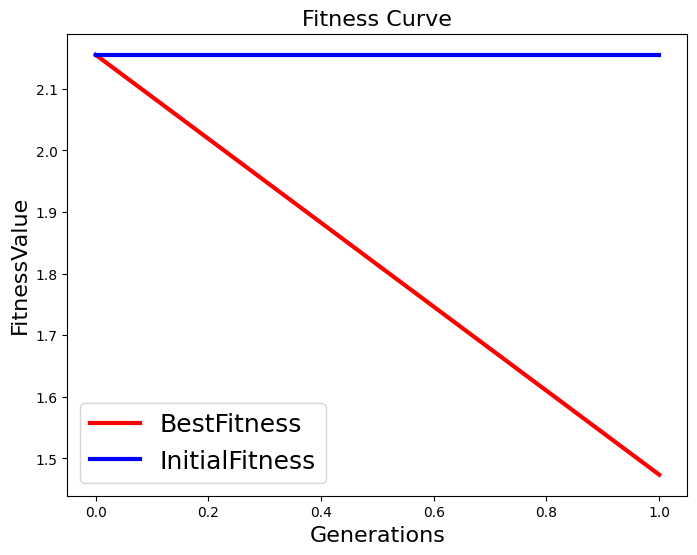

In [5]:
# MAIN

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
from copy import deepcopy
from random import sample
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def initialize_population(population_size, dataset):
    print("----->Initializing Population")
    daddy = compute_parent(dataset)                                 # load parent from input
    population = [daddy]
    for it in range(1, population_size):
        population.append(daddy.asexual_reproduction(it, dataset))

    # sort population on ascending order based on fitness
    return sorted(population, key=lambda cnn: cnn.fitness)


def selection(k, population, num_population):
    if k == 0:                                              # elitism selection
        print("----->Elitism selection")
        return population[0], population[1]
    elif k == 1:                                            # tournament selection
        print("----->Tournament selection")
        i = randint(0, num_population - 1)
        j = i
        while j < num_population - 1:
            j += 1
            if randint(1, 100) <= 50:
                return population[i], population[j]
        return population[i], population[0]
    else:                                                   # proportionate selection
        print("----->Proportionate selection")
        cum_sum = 0
        for i in range(num_population):
            cum_sum += population[i].fitness
        perc_range = []
        for i in range(num_population):
            count = 100 - int(100 * population[i].fitness / cum_sum)
            for j in range(count):
                perc_range.append(i)
        i, j = sample(range(1, len(perc_range)), 2)
        while i == j:
            i, j = sample(range(1, len(perc_range)), 2)
        return population[perc_range[i]], population[perc_range[j]]


def crossover(parent1, parent2, it):
    print("----->Crossover")
    child = Network(it)

    first, second = None, None
    if randint(0, 1):
        first = parent1
        second = parent2
    else:
        first = parent2
        second = parent1

    child.block_list = deepcopy(first.block_list[:randint(1, len(first.block_list) - 1)]) \
                       + deepcopy(second.block_list[randint(1, len(second.block_list) - 1):])

    order_indexes(child)                            # order the indexes of the blocks

    return child


def genetic_algorithm(num_population, num_generation, num_offspring, dataset, early_stopping_generations=3):
    print("Genetic Algorithm")

    population = initialize_population(num_population, dataset)

    print("\n-------------------------------------")
    print("Initial Population:")
    for cnn in population:
        print(cnn.name, ': ', cnn.fitness)
    print("--------------------------------------\n")

    # for printing statistics about fitness and the number of parameters of the best individual
    stats = [(population[0].fitness, population[0].model.count_params())]

    # Initialize a variable to keep track of consecutive generations with the same best fitness
    consecutive_same_fitness = 0

    for gen in range(1, num_generation + 1):
        '''
            k is the selection parameter:
                k = 0 -> elitism selection
                k = 1 -> tournament selection
                k = 2 -> proportionate selection
        '''
        k = randint(0, 2)

        print("\n------------------------------------")
        print("Generation -----------------------------------------------------------------------------------", gen)
        print("-------------------------------------")

        for c in range(num_offspring):

            print("\nCreating Child", c)

            parent1, parent2 = selection(k, population, num_population)                 # selection
            print("Selected", parent1.name, "and", parent2.name, "for reproduction")

            child = crossover(parent1, parent2, c + num_population)                     # crossover
            print("Child has been created")

            print("----->Soft Mutation")
            child.layer_mutation(dataset)                                               # mutation
            child.parameters_mutation()
            print("Child has been mutated")

            model = child.build_model()                                                 # evaluation

            while model == -1:
                child = crossover(parent1, parent2, c + num_population)
                child.block_mutation(dataset)
                child.layer_mutation(dataset)
                child.parameters_mutation()
                model = child.build_model()

            child.train_and_evaluate(model, dataset)

            if child.fitness < population[-1].fitness:                                  # evolve population
                print("----->Evolution: Child", child.name, "with fitness", child.fitness, "replaces parent ", end="")
                print(population[-1].name, "with fitness", population[-1].fitness)
                name = population[-1].name

                child.save_network("child_model_info.pkl", "child_model.h5")
                population[-1].load_network("child_model_info.pkl", "child_model.h5")

                population[-1].name = name
                population = sorted(population, key=lambda net: net.fitness)
            else:
                print("----->Evolution: Child", child.name, "with fitness", child.fitness, "is discarded")
        
        if gen >= 3 and all(population[i].fitness == population[i + 1].fitness for i in range(-3, -1)):
            consecutive_same_fitness += 1
            print(f"Consecutive generations with the same best fitness: {consecutive_same_fitness}")
        if consecutive_same_fitness >= 3:
            print("Stopping the algorithm as the best fitness has remained the same for the last 3 generations.")
            break
    else:
        consecutive_same_fitness = 0
        
       #Check if the best fitness has remained the same for the last early_stopping_generations generations
        if all(population[i].fitness == population[i + 1].fitness for i in range(-early_stopping_generations, -1)):
            consecutive_same_fitness += 1
            print(f"Consecutive generations with the same best fitness: {consecutive_same_fitness}")
            if consecutive_same_fitness == early_stopping_generations:
                print(f"Stopping the algorithm as the best fitness has remained the same for {early_stopping_generations} generations.")
        else:
            consecutive_same_fitness = 0
        stats.append((population[0].fitness, population[0].model.count_params()))

    print("\n\n-------------------------------------")
    print("Final Population")
    print("-------------------------------------\n")
    for cnn in population:
        print(cnn.name, ': ', cnn.fitness)

    print("\n-------------------------------------")
    print("Stats")
    for i in range(len(stats)):
        print("Best individual at generation", i + 1, "has fitness", stats[i][0], "and parameters", stats[i][1])
    print("-------------------------------------\n")

    # plot the fitness and the number of parameters of the best individual at each iteration
    plot_statistics(stats)

    return population[0]

import os
import cv2  # OpenCV
import numpy as np


def main():    
        #with strategy.scope():
        #from tensorflow.python.client import device_lib
        #print(device_lib.list_local_devices())
        #batch_size = 8
        #batch_size = batch_size * strategy.num_replicas_in_sync
        batch_size = 32                       # the number of training examples in one forward/backward pass
        num_classes = 20                       # number of cifar-10 dataset classes
        epochs = 30             # number of forward and backward passes of all the training examples
        image_size = (32,32) # Adjust this according to your image size
        data_dir = '/kaggle/input/cifar-100-20classes'
        '''
            dataset contains the hyper parameters for loading data and the dataset:
                dataset = {
                    'batch_size': batch_size,
                    'num_classes': num_classes,
                    'epochs': epochs,
                    'x_train': x_train,
                    'x_test': x_test,
                    'y_train': y_train,
                    'y_test': y_test
                }
        '''
        #dataset = load_dataset(batch_size, num_classes, epochs)
        dataset=load_dataset(batch_size, num_classes, epochs, image_size, data_dir)
        num_population = 10
        num_generation = 20
        num_offspring = 4

        # plot the best model obtained
        optCNN = genetic_algorithm(num_population, num_generation, num_offspring, dataset)

        # plot the training and validation loss and accuracy
        num_epoch = 20
        model = optCNN.build_model()
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(dataset['x_train'],
                            dataset['y_train'],
                            batch_size=dataset['batch_size'],
                            epochs=num_epoch,
                            validation_data=(dataset['x_test'], dataset['y_test']),
                            shuffle=True)
        optCNN.model = model                                        # model
        optCNN.fitness = history.history['val_loss'][-1]            # fitness

        print("\n\n-------------------------------------")
        print("The Final CNN has been evolved successfully in the individual", optCNN.name)
        print("-------------------------------------\n")
        daddy = load_network('parent_0')
        model = tf.keras.models.load_model('parent_0.h5')
        print("\n\n-------------------------------------")
        print("Summary of initial CNN")
        print(model.summary())
        print("Fitness of initial CNN:", daddy.fitness)

        print("\n\n-------------------------------------")
        print("Summary of evolved individual")
        print(optCNN.model.summary())
        print("Fitness of the evolved individual:", optCNN.fitness)
        print("-------------------------------------\n")

        plot_training(history)


if __name__ == '__main__':
    main()


## To remove a folder
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)